## Making Characters Count

Loading the needed libraries:

In [73]:
import pandas as pd

import regex as re

import matplotlib.pyplot as plt

from collections import Counter

Loading in the manuscripts, their content and their metadata:

In [6]:
transcriptions = pd.read_excel('data/manuscript_data_metadata_rich.xlsx')

# The id-column is a concatenation of the signature of the codex, the production unit, and the scribe of the unit
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

,codex_sig,transkribuspage,image_filename,page_xml_filename_x,image_width,image_height,region_type,coordinates,fraction,text,...,production unit,local Herne product,date,translator,transcription,HTR-model used,expanded,lemmas,POS,id
0,"Brussel, KBR, 1805-1808",7.0,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",0.01,Een voorredene op sinte gregoriꝰ dyalogus,...,I,yes,1400,bibletranslator,GT,NaN,eenevoorren,eenvoorder,adj(),"Brussel, KBR, 1805-1808-I-a"
1,"Brussel, KBR, 1805-1808",7.0,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",0.12,DE zeere wise e saleghe gregoris paeus\nvan d...,...,I,yes,1400,bibletranslator,GT,NaN,de zeere wise ende saleghe gregoris paeus\nvan...,de zeer wijs en zalig gregorius paus\nvan de s...,art(def) adv(gener) n(sing) conj(coord) adj() ...,"Brussel, KBR, 1805-1808-I-a"
2,"Brussel, KBR, 1805-1808",8.0,47180129.tiff,0008_KBR_1805-08_1v.xml,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",0.06,wiste dat si hare te xpūs gheloeue ghege-\nuen...,...,I,yes,1400,bibletranslator,GT,NaN,wiste dat si hare te cpuns gheloeue ghegeuen\n...,weten dat zij zij te kunnen geloof geven\nhebb...,"v(fin,past,lex) conj(subord) pron(pers,3,sing)...","Brussel, KBR, 1805-1808-I-a"
3,"Brussel, KBR, 1805-1808",8.0,47180129.tiff,0008_KBR_1805-08_1v.xml,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",0.01,⸫ Nēmeer en vant ics jnt latijn .,...,I,yes,1400,bibletranslator,GT,NaN,ennemmeerticsetijntm,eniterminsteken,misc(),"Brussel, KBR, 1805-1808-I-a"
4,"Brussel, KBR, 1805-1808",9.0,0009_KBR_1805-08_2r.tiff,0009_KBR_1805-08_2r.xml,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",0.23,Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...,...,I,yes,1395,bibletranslator,GT,NaN,hier beghint een voerredene\nop gregorius dyal...,hier beginnen een voorreden\nop gregorius dial...,"adv(dem) v(fin,pres,lex) art(indef) n(sing)\na...","Brussel, KBR, 1805-1808-I-α"


We merge together all texts from the same production units (pu).

In [23]:
units = []
plain_char = re.compile("[A-Za-z]+")

for pu_id, pu in transcriptions.groupby('id'):
    pu = pu.sort_values('transkribuspage')
    pu = pu[~pu['text'].isna()]
    if not len(pu):
        continue
    text = ' '.join(t for t in pu['text']) # join all texts together (for the same pu)
    text = ' '.join(text.strip().split())
    
    date = pu.sample(1)['date'].values[0]
    scribe = pu.sample(1)['scribe'].values[0]
    sig = pu.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(pu['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = pu.sample(1)['translator'].values[0]
    units.append((pu_id, date, text, scribe, sig, pu_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H

,pu,date,text,scribe,signature,id,translator,content
0,"Brussel, KBR, 1805-1808-I-a",1400,Een voorredene op sinte gregoriꝰ dyalogus DE z...,"Brussel, KBR, 1805-1808-a","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-I-a",bibletranslator,<UNK>
1,"Brussel, KBR, 1805-1808-I-α",1395,Hier beghint een voʼredene op .Sʼ. gᵉgorius dy...,α,"Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-I-α",bibletranslator,<UNK>
2,"Brussel, KBR, 1805-1808-II-D",1395,Hiʼ begēt de pierde boec vā gᵉgerna ¶ Dyalogus...,"Brussel, KBR, 1805-1808-D","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-II-D",bibletranslator,<UNK>
3,"Brussel, KBR, 1805-1808-II-α",1395,De dʼde boec gaꝫ hiʼ vte Hiʼ volgen dē capitee...,α,"Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-II-α",none,<UNK>
4,"Brussel, KBR, 1805-1808-III-none",1395,DJt boec hoert den bruedʼs vādē goede cloestin...,"Brussel, KBR, 1805-1808-none","Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-III-none",none,<UNK>
...,...,...,...,...,...,...,...,...
105,"Wenen, ÖNB, 65-I-a",1375-1400,liber iste ꝑtinet ad cenob sā pauli zonia Dor...,"Wenen, ÖNB, 65-a","Wenen, ÖNB, 65","Wenen, ÖNB, 65-I-a",NaN,<UNK>
106,"Wenen, ÖNB, 65-I-γ",1375-1400,‡ d blie die pase on heeren ihoes so voerga en...,γ,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-I-γ",NaN,<UNK>
107,"Wenen, ÖNB, 65-II-α",1375-1400,huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...,α,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-II-α",NaN,<UNK>
108,"Wenen, ÖNB, 65-III-γ",1375-1400,vᵃ De wijsheit . Dat en mach niet sijn . Noch ...,γ,"Wenen, ÖNB, 65","Wenen, ÖNB, 65-III-γ",NaN,<UNK>


In [22]:
# @ Mike: alle content is unk ?

set(H['content'])

# ik begrijp ook niet goed wat hier precies gebeurt:

#     date = pu.sample(1)['date'].values[0]
#     scribe = pu.sample(1)['scribe'].values[0]
#     sig = pu.sample(1)['codex_sig'].values[0]
#     content = '<UNK>'

{'<UNK>'}

In [30]:
# If a date is approximated (f.e. 1325-1350), we have to convert it 
# to *one* year in order to work with it. Accordingly, we calculate
# the mean and store it in the num_date-column

num_dates = []

for d in H['date']:
    if d in ('unknown', 'no', 'none'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
71,"Sint-Petersburg, BAN, O 256-II-G",1325-1350,es and net aeroeg ē en wna M8 Sadoch ghebaer a...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-G",NaN,<UNK>,1337.5,127527
73,"Sint-Petersburg, BAN, O 256-III-G",1325-1350,mar gheest nedʼ comēde alse ene dune e bliuēd...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-III-G",NaN,<UNK>,1337.5,69353
20,"Brussel, KBR, 2879-80-I-scribe1",1325-1350,GOd die de clare Mᵉ die onbekint was vʼclaerde...,scribe1,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe1",none,<UNK>,1337.5,39574
72,"Sint-Petersburg, BAN, O 256-II-III-G",1325-1350,Mathʼs bᵒch daer hen ihesus hodde ghesect Ende...,"Sint-Petersburg, BAN, O 256-G","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-II-III-G",NaN,<UNK>,1337.5,1436
67,"Sint-Petersburg, BAN, O 256-I-A",1325-1350,,"Sint-Petersburg, BAN, O 256-A","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-A",NaN,<UNK>,1337.5,0
...,...,...,...,...,...,...,...,...,...,...
66,"Parijs, Bibliothèque de l'Arsenal, 8224-none-u...",none,,"Parijs, Bibliothèque de l'Arsenal, 8224-unknown","Parijs, Bibliothèque de l'Arsenal, 8224","Parijs, Bibliothèque de l'Arsenal, 8224-none-u...",NaN,<UNK>,NaN,0
77,"Sint-Petersburg, BAN, O 256-none-none",none,,"Sint-Petersburg, BAN, O 256-none","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-none-none",NaN,<UNK>,NaN,0
81,"Wenen, ÖNB, 12.857-none-none",no,. Die .iiij. euangelisten .,"Wenen, ÖNB, 12.857-none","Wenen, ÖNB, 12.857","Wenen, ÖNB, 12.857-none-none",NaN,<UNK>,NaN,27
86,"Wenen, ÖNB, 12.905-none-none",none,sche wijf op sittet . Dꝫ sijn die liede e die...,"Wenen, ÖNB, 12.905-none","Wenen, ÖNB, 12.905","Wenen, ÖNB, 12.905-none-none",NaN,<UNK>,NaN,846


In [32]:
# Filters out any text with a length less than 2500 characters

print(len(H))
H = H[H['length'] > 1000]
print(len(H))

110
76


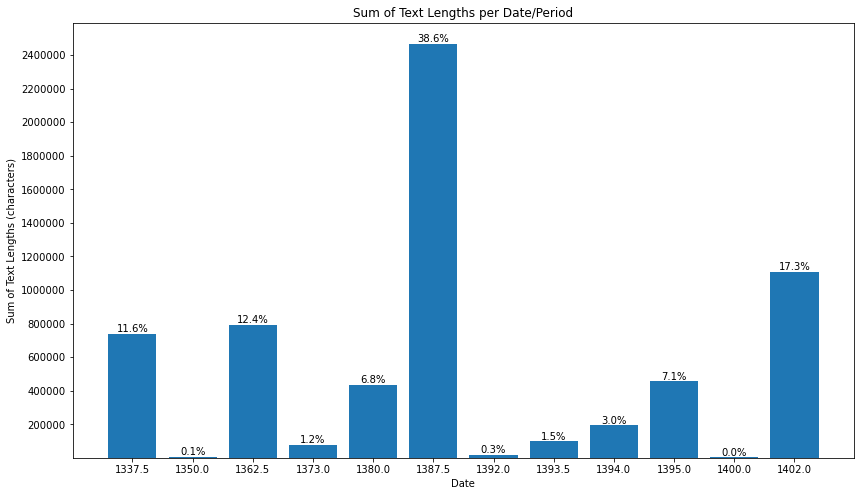

In [71]:
# Creating a bar plot with the (estimated) date on the x-axis 
# and the text length in characters on the y-axis. The percentages
# indicate the percentage of characters present in a certain year,
# in relation to all the characters in the corpus

import matplotlib.pyplot as plt

# Group data by 'num_date' and sum the 'length' column
grouped_data = H.groupby('num_date')['length'].sum().reset_index()

# Calculate the total length for all dates
total_length = grouped_data['length'].sum()

# Calculate the percentage for each date
grouped_data['percentage'] = (grouped_data['length'] / total_length) * 100

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Define the x-values for the bars
x_values = range(len(grouped_data['num_date']))

bars = plt.bar(x_values, grouped_data['length'])

# Set the x-ticks to correspond to the years
plt.xticks(x_values, grouped_data['num_date'])

# Title and labels
plt.title('Sum of Text Lengths per Date/Period')
plt.xlabel('Date')
plt.ylabel('Sum of Text Lengths (characters)')

# Set the desired y-labels
y_labels = list(range(200000, 2600000, 200000))
plt.yticks(y_labels, [str(label) for label in y_labels])

# Show the percentages above the bars
for bar, percentage in zip(bars, grouped_data['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the plot
plt.show()


## Graphemes

We separate the characters into three categories: letters, glyphs, and punctuation.

In [74]:
allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
allowed_chars

Counter({'E': 5500,
         'e': 208715,
         'n': 62178,
         ' ': 259428,
         'v': 16520,
         'o': 44860,
         'r': 34693,
         'd': 69361,
         'p': 7881,
         's': 61677,
         'i': 66844,
         't': 68258,
         'g': 31082,
         'ꝰ': 847,
         'y': 2032,
         'a': 49368,
         'l': 42615,
         'u': 20062,
         'D': 6957,
         'z': 1263,
         'w': 19107,
         '\ue5dc': 12539,
         'h': 45660,
         '\n': 42402,
         'm': 26172,
         'b': 13885,
         'c': 30966,
         'k': 8726,
         'ē': 41857,
         'ʼ': 23986,
         '.': 16628,
         'W': 2113,
         '-': 6414,
         'ū': 290,
         'ā': 8160,
         '\uf161': 50,
         'H': 1711,
         'j': 4608,
         'f': 5574,
         'x': 1582,
         '⸫': 212,
         'N': 1097,
         'S': 2022,
         'ᵉ': 1224,
         'O': 871,
         'ꝑ': 314,
         'ᵃ': 1518,
         'ꝫ': 7401,
         '